In [260]:
import matplotlib.pyplot as plt


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / "_scripts"))

In [368]:
import networkx as nx
from eppy.bunch_subclass import EpBunch
from geomeppy import IDF
import seaborn as sns
import polars as pl
from datetime import datetime
from ladybug.dt import DateTime
from matplotlib.patches import FancyArrowPatch
from itertools import accumulate

from case_edits.ezcase import *
from helpers.ep_helpers import *
from helpers.ep_geom_helpers import *
from helpers.geometry_interfaces import *
from helpers.helpers import *
from plan.helpers import get_plans_from_file
from network.network import *
from network.visuals import *
from subsurfaces.logic import get_connecting_surface
from helpers.variables import *
from helpers.variable_interfaces import *
from helpers.read_sql import *

from case_edits.epcase import EneryPlusCaseEditor
from helpers.output_requests import request_sql

from setup.setup import get_case_names, CaseData, retrieve_cases
from setup.plots import *
from setup.data_wrangle import *
from network.data_on_network import *

import matplotlib.cm as cm
import matplotlib as mpl



In [205]:
qoi1 = 'AFN Linkage Node 1 to Node 2 Volume Flow Rate'
qoi12 = 'AFN Linkage Node 2 to Node 1 Volume Flow Rate'

qoi2 = "Site Wind Speed"
qoi3 = "Site Wind Direction"

qoi4 = all_variables.afn.zone["ach"]

In [195]:
case_data = retrieve_cases()
sample_case  = case_data[0]
case_name, idf, sql, path_to_input, path_to_output = sample_case

In [386]:
qois = [qoi1, qoi12]
df = create_dataframe_for_all_cases(case_data, qoi1)
# df2 = join_site_data(sample_case, qoi2, df1, 1)
df1 = join_any_data(df, case_data, qoi12)
df_case = df1.filter(pl.col("case_names") == sample_case.case_name)
df_case.head()

case_names,space_names,qoi,values,datetimes,qoi_0,values_0
str,str,str,f64,datetime[μs],str,f64
"""amb_b1""","""BLOCK 01 STOREY 0 WALL 0001_2 …","""AFN Linkage Node 1 to Node 2 V…",0.189875,2017-07-01 00:00:00,"""AFN Linkage Node 2 to Node 1 V…",0.163262
"""amb_b1""","""BLOCK 01 STOREY 0 WALL 0001_2 …","""AFN Linkage Node 1 to Node 2 V…",0.229261,2017-07-01 00:15:00,"""AFN Linkage Node 2 to Node 1 V…",0.157707
"""amb_b1""","""BLOCK 01 STOREY 0 WALL 0001_2 …","""AFN Linkage Node 1 to Node 2 V…",0.262846,2017-07-01 00:30:00,"""AFN Linkage Node 2 to Node 1 V…",0.13922
"""amb_b1""","""BLOCK 01 STOREY 0 WALL 0001_2 …","""AFN Linkage Node 1 to Node 2 V…",0.285586,2017-07-01 00:45:00,"""AFN Linkage Node 2 to Node 1 V…",0.125513
"""amb_b1""","""BLOCK 01 STOREY 0 WALL 0001_2 …","""AFN Linkage Node 1 to Node 2 V…",0.28513,2017-07-01 01:00:00,"""AFN Linkage Node 2 to Node 1 V…",0.124467


In [304]:
medians = df_case.group_by(pl.col("space_names")).agg(pl.col(["values", "values_0"]).median())
medians

space_names,values,values_0
str,f64,f64
"""BLOCK 09 STOREY 0 WALL 0002_1 …",0.020381,0.141742
"""BLOCK 01 STOREY 0 WALL 0003 WI…",0.048745,0.292995
"""BLOCK 01 STOREY 0 WALL 0001_2 …",0.042763,0.249457
"""BLOCK 010 STOREY 0 WALL 0002_2…",0.014386,0.224106
"""BLOCK 08 STOREY 0 WALL 0002_1 …",0.0,0.411991
…,…,…
"""BLOCK 09 STOREY 0 WALL 0002_2 …",0.041048,0.129225
"""BLOCK 010 STOREY 0 WALL 0002_1…",0.003296,0.219314
"""BLOCK 01 STOREY 0 WALL 0001_1 …",0.0,0.206432


In [338]:
max_val = medians.select(pl.selectors.numeric()).max_horizontal().max()
min_val = medians.select(pl.selectors.numeric()).min_horizontal().min()
min_val, max_val

(0.0, 0.6398376676926416)

In [319]:
G, pos = create_base_graph(idf, path_to_input)
Gm = create_multi_graph(G)

In [340]:
edges = [get_matching_edge(Gm, s) for s in medians["space_names"]]
rev_edges = [(e[1], e[0], e[2]) for e in edges]
rev_edges

[('6-den', '9-e_living', 0),
 ('WEST', '1-w_living', 0),
 ('9-e_living', '1-w_living', 0),
 ('10-transit2', '3-bed_1', 0),
 ('10-transit2', '8-transit', 0),
 ('3-bed_1', 'NORTH', 0),
 ('6-den', '8-transit', 0),
 ('8-transit', '9-e_living', 0),
 ('10-transit2', '0-w_bed', 0),
 ('8-transit', '1-w_living', 0),
 ('SOUTH', '1-w_living', 0),
 ('NORTH', '0-w_bed', 0)]

In [388]:
case_info, qoi_info = get_plot_labels(sample_case, qoi1)

'AFN Linkage Node 1 to Node 2 Volume Flow Rate [m3/s]'

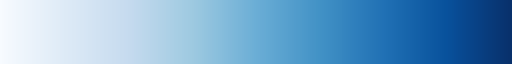

In [377]:
cmap = plt.get_cmap("Blues")
cmap

Text(0.5, 0.98, 'Case: amb_b1')

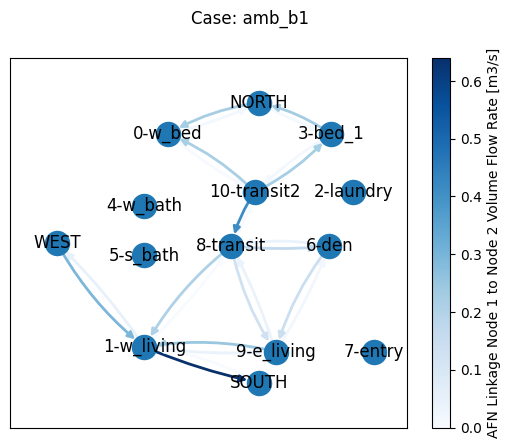

In [391]:
connectionstyle = [f"arc3,rad={r}" for r in accumulate([0.05] * 2)]

fig, ax = plt.subplots()
_ = nx.draw_networkx_nodes(Gm, pos, margins=(.1, .1), ax=ax)
p = nx.draw_networkx_labels(Gm, pos, ax=ax)


p = nx.draw_networkx_edges(Gm, pos, edgelist=edges, edge_color=medians["values"], edge_cmap=cmap, edge_vmin=min_val,edge_vmax=max_val, connectionstyle=connectionstyle[0], width=2, ax=ax)

p = nx.draw_networkx_edges(Gm, pos, edgelist=rev_edges, edge_color=medians["values_0"], edge_cmap=cmap, edge_vmin=min_val,edge_vmax=max_val, connectionstyle=connectionstyle[1], width=2, ax=ax)

norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label=qoi_info)
fig.suptitle(case_info)

In [374]:
fig